# PsyNeuLink: Stroop Model
> Colab tip: Open the left sidebar (☰)  -> **Table of Contents** to navigate this notebook.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AutoResearch/ASDMB-Workshop/blob/main/ASDMB-book/content/practical-sessions/psyneulink/psyneulink.ipynb)


## Content

- [0. Setup and Installation](#setup-and-installation)
- [1. Basics](#basics)
- [2. Linear Stroop](#linear-stroop)
- [3. Stroop with Task Demand](#stroop-with-task-demand)
- [4. Stroop With Conflict Monitoring](#stroop-with-conflict-monitoring)


## 0. Setup and Installation

Run this once (or whenever you restart the runtime). This will install PsyNeuLink and import it.

In [1]:
%%capture
try:
    import psyneulink as pnl
    import numpy as np
    import matplotlib.pyplot as plt
    print("psyneulink already installed")
except ImportError:
    %pip install psyneulink
    import psyneulink as pnl

psyneulink already installed


## 1. Basics

**Content**

- [Mechanisms](#Mechanisms)
- [Compositions](#Compositions)
- [Show Graph](#Show-Graph)

### Mechanisms

Let's create our first composition in PsyNeuLink that consists of only two mechanisms: `Input` and `Output`. We will give both of them `2` input- and output-ports. For the `Input` we leave `Linear` (the default value) as function, for the `Output`, we will assign a Logistic function. Following machine learning conventions, we will use the term `layer` to refer to these mechanisms.



In [70]:
input_layer = pnl.ProcessingMechanism(name="Input", input_shapes=2)
output_layer = pnl.ProcessingMechanism(name="Output", input_shapes=2, function=pnl.Logistic)

### Compositions

We can now combine these two layers into a `Compositions` object. First, we will define a `pathway` via a list. When we give this pathway to PsyNeuLink it will automatically create a `MappingProjection` between the two layers with reasonable default parameters. In this case, it will create a identity matrix (2x2) wiring the output-port of the `input_layer` to the input-port of the `output_layer`.

In [71]:
in_out_pathway = [input_layer, output_layer]
simple_comp = pnl.Composition(name="simple_comp", pathways=[in_out_pathway]) # Note: pathways expects a list of lists (or pathways

We can execute mechanisms individually by passing an array of the appropriate size:

In [72]:
input_layer.execute([0, 1])

array([[0., 1.]])

We can also execute the entire composition by passing an array to the `run` method:

In [73]:
simple_comp.run([0, 1])

array([[0.5       , 0.73105858]])

or with a list of inputs. The results are stored in the `results` attribute of the compositions.

In [74]:
simple_comp.run([[0, 1], [1, 0], [0.5, 0.5]])
simple_comp.results # Note this also shows the results of the previous run (when running this multiple times the results will be appended)

array([[[0.5       , 0.73105858]],

       [[0.5       , 0.73105858]],

       [[0.73105858, 0.5       ]],

       [[0.62245933, 0.62245933]]])

### Show Graph

A very handy feature of PsyNeuLink is the ability to visualize the composition as a graph:

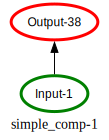

In [75]:
simple_comp.show_graph(output_fmt='jupyter')

The show graph function has many options to customize the output. For example, we can show a more detailed view of the nodes by setting `show_node_structure=True`:

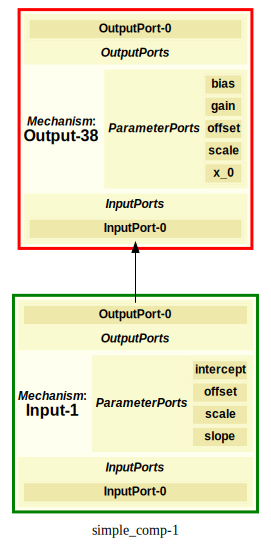

In [76]:
simple_comp.show_graph(output_fmt='jupyter', show_node_structure=True)

### Projections

So far we have only implicitly created a `MappingProjection` by passing a list of mechanisms as a `pathway`. However, if we want more control over the projection, we can create it explicitly. To do so, we define a weight matrix and pass it to the `MappingProjection` constructor. The weight matrix needs to have a shape that is compatible with the output-port of the sender mechanism and the input-port of the receiver mechanism. In this case, both layers have 2 input- and output-ports, so we can use a 2x2 matrix (To make it easier to see, we will use input and output layers with linear identity functions):


In [77]:
input_layer = pnl.ProcessingMechanism(name="Input", input_shapes=2)
output_layer = pnl.ProcessingMechanism(name="Output", input_shapes=2)

# matrix is defined as a list of matrix columns
matrix = [[1, 2],  # weights from input_layer[0] to output_layer[0, 1]
          [3, 4]]  # weights from input_layer[1] to output_layer[0, 1]

projection = pnl.MappingProjection(matrix=matrix)

# Here we show another way of adding a pathway after the composition has been created
simple_comp = pnl.Composition(name="simple_comp")
simple_comp.add_linear_processing_pathway([input_layer, projection, output_layer])

Again, we can run the composition

In [78]:
simple_comp.run([0, 1])

array([[3., 4.]])

In this case, the output can be understood as matrix multiplication between

$$
\begin{bmatrix}
1 & 3 \\
2 & 4
\end{bmatrix}
\cdot
\begin{bmatrix}
0 \\
1
\end{bmatrix}
=
\begin{bmatrix}
3 \\
4
\end{bmatrix}
$$



<details>
<summary>
What is the output of the composition if we run it with input `[1, 1]`?
</summary>
$$
\begin{bmatrix}
1 & 3 \\
2 & 4
\end{bmatrix}
\cdot
\begin{bmatrix}
1 \\
1
\end{bmatrix}
=
\begin{bmatrix}
4 \\
6
\end{bmatrix}
$$
</details>

In [79]:
simple_comp.run([1, 1])

array([[4., 6.]])

## 2. Linear Stroop

With the above basics, we can already implement simple models. Here, we will implement a simple version that aims to explain conflict:

![multitasking](https://raw.githubusercontent.com/AutoResearch/ASDMB-Workshop/main/ASDMB-book/_static/img/practical-sessions/spongebob-spongebob-squarepants.gif)

Pat your head and rub your belly at the same time. Unless you have practiced this odd exercise you will get conflict between the motor commands and quickly end up rubbing your head while also rubbing your belly, OR patting your belly while also patting your head. As a more difficult exercise, while sitting, lift your right foot and repeatedly rotate it clockwise while simultaneously tracing a counterclockwise circle in the air with your right hand.

These are examples of **cognitive conflict**. When you are trying to do two things ar once conflict can arise. Other things however, you can do simultaneously without experiencing conflict. For example, you can walk and have a conversation at the same time, or you can eat and watch TV at the same time.

The Stroop Model explains this conflict with shared pathways (or representations). In the classical Stroop Task, the participants are asked to name the color of the ink a word is printed in. The word itself also has the meaning of a color. For example, the word "RED" printed in blue ink. Our model proposes that both recognizing a color and reading a color word share common representations (in our case in the output layer). When the color and meaning match, these representation "work together" and the task is easy. However, when they mismatch, they "work against each other" and cause conflict.

Don't worry if this is not clear yet, it will be once we have implemented the model:


### Task & Model

We will implement a simple version of the Stroop model. The task consists of 2x2 conditions:


- word: RED, GREEN -> one-hot encoded as [1, 0] and [0, 1]
- color: red, green -> one-hot encoded as [1, 0] and [0, 1]

---

- <span style="color:red">RED</span> -> word: [1, 0], color: [1, 0]
- <span style="color:green">RED</span> -> word: [1, 0], color: [0, 1]
- <span style="color:green">GREEN</span> -> word: [0, 1], color: [0, 1]
- <span style="color:red">GREEN</span> -> word: [0, 1], color: [1, 0]

To model the more "automatic" response to word reading, we will give the word input a stronger connection to the output layer then the color input:



In [80]:
# Some CONSTANTS: Strength of processing pathways:
WORD_STRENGTH = 3
COLOR_STRENGTH = 2
TASK_STRENGTH = 4

In [81]:
def get_linear_stroop():
    # input layers (shape == 2 for one-hot encoded inputs)
    word_input = pnl.ProcessingMechanism(name="Word", input_shapes=2)
    color_input = pnl.ProcessingMechanism(name="Color", input_shapes=2)

    # output layer (shape == 2 for one-hot encoded output red or green)
    response = pnl.ProcessingMechanism(name="Response", input_shapes=2)

    # create the compositions
    comp = pnl.Composition(name="Linear Stroop")

    # Create the projections
    # here we define a simple lateral inhibition matrix (i.e., input to red inhibits green and vice versa)
    inhibition_matrix = np.array(
        [[1, -1.],
         [-1., 1]])

    # scale the inhibition matrix by the processing strength
    word_processing_matrix = WORD_STRENGTH * inhibition_matrix
    color_processing_matrix = COLOR_STRENGTH * inhibition_matrix

    # create projections
    word_response_projection = pnl.MappingProjection(matrix=word_processing_matrix)
    color_response_projection = pnl.MappingProjection(matrix=color_processing_matrix)

    # Add pathways to the composition
    comp.add_linear_processing_pathway([
        word_input, word_response_projection, response
    ])

    comp.add_linear_processing_pathway([color_input, color_response_projection, response])
    return comp, word_input, color_input

Let's look at the graph of the model:

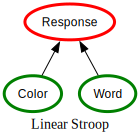

In [82]:
linear_stroop, _, _= get_linear_stroop()

linear_stroop.show_graph(output_fmt='jupyter')

We see, that both color and word input project to the same output layer. Let's see what happens for different inputs. Here, we define the inputs as dictionary with the keys being the input layers:


In [83]:
linear_stroop, word_input, color_input = get_linear_stroop()

# Congruent Stimuli
print(f'{"*"*10}Congruent Stimuli{"*"*10}')
# RED written in red:
rr = {word_input: [1, 0], color_input: [1, 0]}
response_r, response_g = linear_stroop.run(rr)[0]
print('RED written in red:\n',
      f'Red response activation: {response_r}\n'
      f'Green response activation: {response_g}\n')

# GREEN written in green:
gg = {word_input: [0, 1], color_input: [0, 1]}
response_r, response_g = linear_stroop.run(gg)[0]
print('GREEN written in green:\n',
      f'Red response activation: {response_r}\n'
      f'Green response activation: {response_g}\n')

# Incongruent Stimuli
print(f'{"*"*10}Incongruent Stimuli{"*"*10}')
# RED written in green:
rg = {word_input: [1, 0], color_input: [0, 1]}
response_r, response_g = linear_stroop.run(rg)[0]
print('RED written in green:\n',
      f'Red response activation: {response_r}\n'
      f'Green response activation: {response_g}\n')

# green written in red:
gr = {word_input: [0, 1], color_input: [1, 0]}
response_r, response_g = linear_stroop.run(gr)[0]
print('GREEN written in red:\n',
      f'Red response activation: {response_r}\n'
      f'Green response activation: {response_g}\n')


**********Congruent Stimuli**********
RED written in red:
 Red response activation: 5.0
Green response activation: -5.0

GREEN written in green:
 Red response activation: -5.0
Green response activation: 5.0

**********Incongruent Stimuli**********
RED written in green:
 Red response activation: 1.0
Green response activation: -1.0

GREEN written in red:
 Red response activation: -1.0
Green response activation: 1.0



The above model can explain "congruency" effects. When the color and word match (congruent stimuli) the difference between the two output units is larger than when they mismatch (incongruent stimuli).

### Adding A Drift Diffusion Module

The numbers are hard to interpret, and we would like to add some stochasticity: "It is more likely to be wrong on incongruent trials, and it is slower". To model this, we can add a Drift Diffusion Module to the response:

![ddm](https://raw.githubusercontent.com/AutoResearch/ASDMB-Workshop/main/ASDMB-book/_static/img/practical-sessions/ddm.png)

In [84]:
def get_ddm_stroop():

    # input layers (shape == 2 for one-hot encoded inputs)
    word_input = pnl.ProcessingMechanism(name="Word", input_shapes=2)
    color_input = pnl.ProcessingMechanism(name="Color", input_shapes=2)

    # output layer (shape == 2 for one-hot encoded output red or green)
    output_layer = pnl.ProcessingMechanism(name="Output", input_shapes=2)

    # DDM for decision making
    decision_layer = pnl.DDM(
        name='Decision',
        input_format=pnl.ARRAY,
        function=pnl.DriftDiffusionIntegrator(
            noise=.5,
            rate=.05,
            threshold=1.
        ),
        reset_stateful_function_when=pnl.AtTrialStart())

    # create the compositions
    comp = pnl.Composition(name="DDM Stroop")

    # Create the projections

    identity_matrix = np.array(
        [[1, -1],
         [-1, 1]])

    # scale the inhibition matrix by the processing strength
    word_processing_matrix = WORD_STRENGTH * identity_matrix
    color_processing_matrix = COLOR_STRENGTH * identity_matrix

    # create projections
    word_response_projection = pnl.MappingProjection(matrix=word_processing_matrix)
    color_response_projection = pnl.MappingProjection(matrix=color_processing_matrix)

    # Add pathways to the composition
    comp.add_linear_processing_pathway([
        word_input, word_response_projection, output_layer
    ])

    comp.add_linear_processing_pathway([color_input, color_response_projection, output_layer])

    comp.add_linear_processing_pathway([output_layer, decision_layer])

    return comp, word_input, color_input

Let's look at the graph of the model:

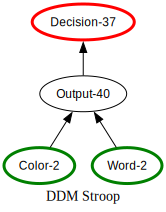

In [85]:
ddm_stroop , _, _ = get_ddm_stroop()

ddm_stroop.show_graph(output_fmt='jupyter')

Now, we can simulate 100 congruent and 100 incongruent trials and look at the rt distributions:

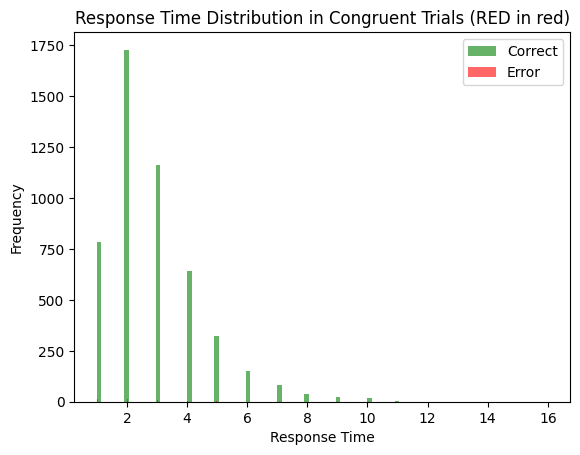

Average correct RT: 2.855040322580645
Accuracy: 0.992


In [86]:
ddm_stroop, word_input, color_input = get_ddm_stroop()

# example congruent stimulus
rr = {word_input: [1, 0], color_input: [1, 0]}

ddm_stroop.run(rr, num_trials= 5000)

results = ddm_stroop.results

decision_times_correct = [r[1][0] for r in results if r[0][0] > 0]  # decision == 1 -> red
decision_time_error = [r[1][0] for r in results if r[0][0] < 0] # decision == -1 -> green

plt.hist(decision_times_correct, bins=100, alpha=0.6, color='green', label='Correct')
plt.hist(decision_time_error, bins=100, alpha=0.6, color='red', label='Error')

plt.title('Response Time Distribution in Congruent Trials (RED in red)')
plt.ylabel('Frequency')
plt.xlabel('Response Time')
plt.legend()
plt.show()
print(f'Average correct RT: {np.mean(decision_times_correct)}')
print(f'Accuracy: {len(decision_times_correct) / (len(decision_times_correct) + len(decision_time_error))}')

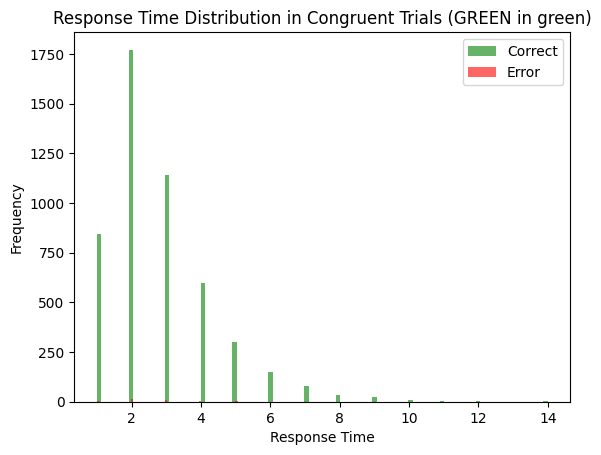

Average correct RT: 2.7992347966169957
Accuracy: 0.9932


In [87]:
ddm_stroop, word_input, color_input = get_ddm_stroop()

# example congruent stimulus
gg = {word_input: [0, 1], color_input: [0, 1]}

ddm_stroop.run(gg, num_trials= 5000)

results = ddm_stroop.results

decision_times_correct = [r[1][0] for r in results if r[0][0] < 0]  # decision == 1 -> green
decision_time_error = [r[1][0] for r in results if r[0][0] > 0] # decision == -1 -> red

plt.hist(decision_times_correct, bins=100, alpha=0.6, color='green', label='Correct')
plt.hist(decision_time_error, bins=100, alpha=0.6, color='red', label='Error')

plt.title('Response Time Distribution in Congruent Trials (GREEN in green)')
plt.ylabel('Frequency')
plt.xlabel('Response Time')
plt.legend()
plt.show()
print(f'Average correct RT: {np.mean(decision_times_correct)}')
print(f'Accuracy: {len(decision_times_correct) / (len(decision_times_correct) + len(decision_time_error))}')

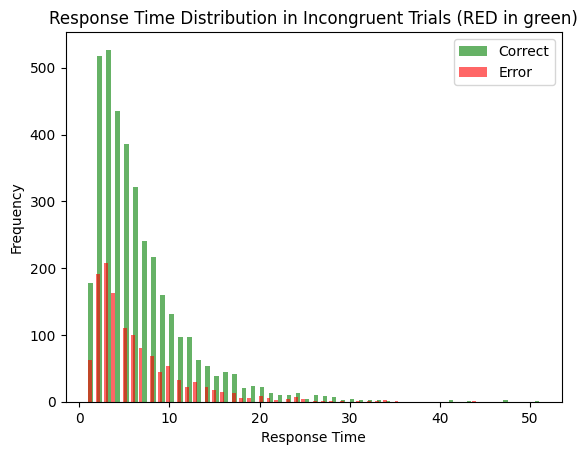

Average correct RT: 6.513469827586207
Accuracy: 0.7424


In [88]:
ddm_stroop, word_input, color_input = get_ddm_stroop()

# example congruent stimulus
rg = {word_input: [1, 0], color_input: [0, 1]}

ddm_stroop.run(rg, num_trials= 5000)

results = ddm_stroop.results

decision_times_correct = [r[1][0] for r in results if r[0][0] > 0]  # decision == 1 -> red
decision_time_error = [r[1][0] for r in results if r[0][0] < 0] # decision == -1 -> green

plt.hist(decision_times_correct, bins=100, alpha=0.6, color='green', label='Correct')
plt.hist(decision_time_error, bins=100, alpha=0.6, color='red', label='Error')

plt.title('Response Time Distribution in Incongruent Trials (RED in green)')
plt.ylabel('Frequency')
plt.xlabel('Response Time')
plt.legend()
plt.show()
print(f'Average correct RT: {np.mean(decision_times_correct)}')
print(f'Accuracy: {len(decision_times_correct) / (len(decision_times_correct) + len(decision_time_error))}')

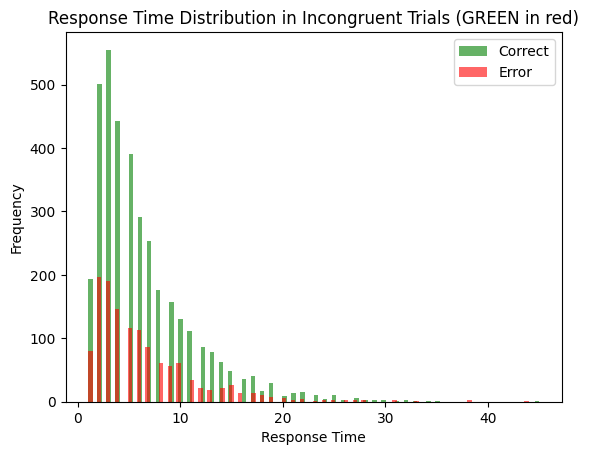

Average correct RT: 6.337127371273713
Accuracy: 0.738


In [89]:
ddm_stroop, word_input, color_input = get_ddm_stroop()

# example congruent stimulus
gr = {word_input: [0, 1], color_input: [1, 0]}

ddm_stroop.run(gr, num_trials= 5000)

results = ddm_stroop.results

decision_times_correct = [r[1][0] for r in results if r[0][0] < 0]  # decision == 1 -> red
decision_time_error = [r[1][0] for r in results if r[0][0] > 0] # decision == -1 -> green

plt.hist(decision_times_correct, bins=100, alpha=0.6, color='green', label='Correct')
plt.hist(decision_time_error, bins=100, alpha=0.6, color='red', label='Error')

plt.title('Response Time Distribution in Incongruent Trials (GREEN in red)')
plt.ylabel('Frequency')
plt.xlabel('Response Time')
plt.legend()
plt.show()
print(f'Average correct RT: {np.mean(decision_times_correct)}')
print(f'Accuracy: {len(decision_times_correct) / (len(decision_times_correct) + len(decision_time_error))}')

## 3. Stroop with Task Demand

Can you name the color?

![stroop-animated](https://raw.githubusercontent.com/AutoResearch/ASDMB-Workshop/main/ASDMB-book/_static/img/practical-sessions/stroop-animated.gif)

The above model suggests that the word-naming process will always overwrite the color-naming. But we can tell from experience that humans can clearly *surpress* the urge to name the word and instead name the color (allthough slower and more error-prone).

To model this, we add a `task_demand` layer that adds activation to either (*both*) word units (RED and GREEN) or (*both*) color units (red and green). To do so, we also add a hidden word and color layers that are calculated from the respective input layer plus the new `task_demand` layer:

In [90]:
def get_task_demand_stroop():
    word_input = pnl.ProcessingMechanism(name="Word In", input_shapes=2)
    color_input = pnl.ProcessingMechanism(name="Color In", input_shapes=2)

    # A new task demand unit ([1,0] -> word naming, [0, 1] ->
    task_demand_input = pnl.ProcessingMechanism(name="Task Demand", input_shapes=2)

    word_hidden = pnl.ProcessingMechanism(name="Word Hidden", input_shapes=2, function=pnl.Logistic(bias=-4))
    color_hidden = pnl.ProcessingMechanism(name="Color Hidden", input_shapes=2, function=pnl.Logistic(bias=-4))

    # output layer (shape == 2 for one-hot encoded output red or green)
    output_layer = pnl.ProcessingMechanism(name="Output", input_shapes=2)

    # DDM for decision making
    decision_layer = pnl.DDM(
        name='Decision',
        input_format=pnl.ARRAY,
        function=pnl.DriftDiffusionIntegrator(
            noise=.5,
            rate=.05,
            threshold=1.
        ),
        reset_stateful_function_when=pnl.AtTrialStart())

    # create the compositions
    composition = pnl.Composition(name="Linear Stroop")

    # Create the projections

    identity_matrix = np.array(
        [[1, -1],
         [-1, 1]])
    word_processing_matrix = WORD_STRENGTH * identity_matrix
    color_processing_matrix = COLOR_STRENGTH * identity_matrix

    # create projections
    word_hidden_projection = pnl.MappingProjection(matrix=word_processing_matrix)
    color_hidden_projection = pnl.MappingProjection(matrix=color_processing_matrix)


    # Add pathways to the composition
    composition.add_linear_processing_pathway([word_input,word_hidden_projection, word_hidden])

    composition.add_linear_processing_pathway([color_input,color_hidden_projection, color_hidden])


    # task -> hidden
    task_word_hidden_matrix = TASK_STRENGTH * np.array(
        [[1, 1],
         [0, 0]])
    task_color_hidden_matrix = TASK_STRENGTH * np.array(
        [[0, 0],
         [1, 1]]
    )

    task_word_hidden_projection = pnl.MappingProjection(matrix=task_word_hidden_matrix)
    task_color_hidden_projection = pnl.MappingProjection(matrix=task_color_hidden_matrix)

    composition.add_linear_processing_pathway([
        task_demand_input,
        task_word_hidden_projection,
        word_hidden
    ])

    composition.add_linear_processing_pathway([
        task_demand_input,
        task_color_hidden_projection,
        color_hidden
    ])

    # scale the inhibition matrix by the processing strength
    word_matrix = WORD_STRENGTH * identity_matrix
    color_matrix = COLOR_STRENGTH * identity_matrix

    # create projections
    word_projection = pnl.MappingProjection(matrix=word_matrix)
    color_projection = pnl.MappingProjection(matrix=color_matrix)

    # hidden -> output
    composition.add_linear_processing_pathway([
        word_hidden, word_projection, output_layer
    ])

    composition.add_linear_processing_pathway([
        color_hidden,color_projection, output_layer
    ])

    # output -> decision

    composition.add_linear_processing_pathway([output_layer, decision_layer])

    return composition, word_input, color_input, task_demand_input

Let's look at the new compostions:

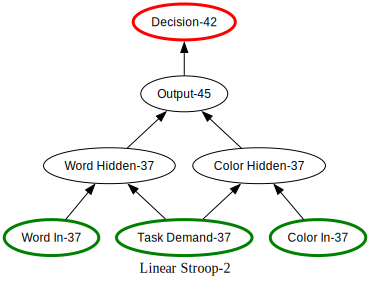

In [91]:
comp, _, _, _ = get_task_demand_stroop()
comp.show_graph(output_fmt='jupyter')

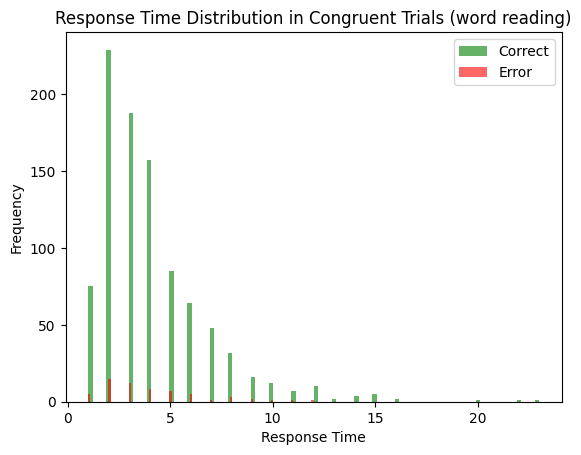

Average correct RT: 4.090521831735889
Accuracy: 0.939


In [92]:
comp, word_input, color_input, task_input = get_task_demand_stroop()

# example congruent stimulus (word meaning)
rr_w = {word_input: [1, 0], color_input: [1, 0], task_input: [1, 0]}

comp.run(rr_w, num_trials= 1000)

results = comp.results# RED written in red

decision_times_correct = [r[1][0] for r in results if r[0][0] > 0]
decision_time_error = [r[1][0] for r in results if r[0][0] < 0]

plt.hist(decision_times_correct, bins=100, alpha=0.6, color='green', label='Correct')
plt.hist(decision_time_error, bins=100, alpha=0.6, color='red', label='Error')

plt.title('Response Time Distribution in Congruent Trials (word reading)')
plt.ylabel('Frequency')
plt.xlabel('Response Time')
plt.legend()
plt.show()
average_rt_congruent_word_reading = np.mean(decision_times_correct)
print(f'Average correct RT: {np.mean(decision_times_correct)}')
print(f'Accuracy: {len(decision_times_correct) / (len(decision_times_correct) + len(decision_time_error))}')

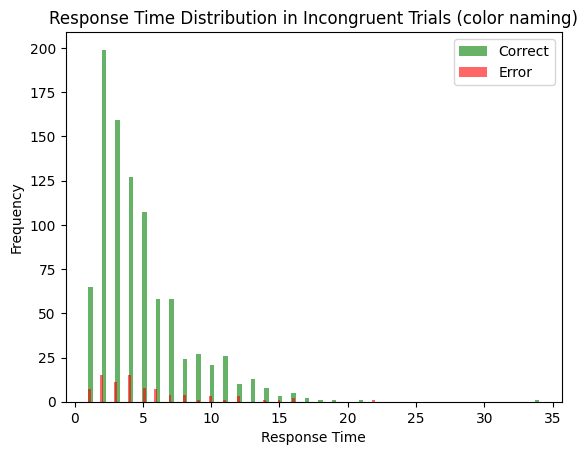

Average correct RT: 4.716157205240175
Accuracy: 0.916


In [93]:
comp, word_input, color_input, task_input = get_task_demand_stroop()

# example incongruent stimulus (word reading)
rg_w = {word_input: [1, 0], color_input: [0, 1], task_input: [1, 0]}

comp.run(rg_w, num_trials= 1000)

results = comp.results# RED written in red

decision_times_correct = [r[1][0] for r in results if r[0][0] > 0]
decision_time_error = [r[1][0] for r in results if r[0][0] < 0]

plt.hist(decision_times_correct, bins=100, alpha=0.6, color='green', label='Correct')
plt.hist(decision_time_error, bins=100, alpha=0.6, color='red', label='Error')

plt.title('Response Time Distribution in Incongruent Trials (color naming)')
plt.ylabel('Frequency')
plt.xlabel('Response Time')
plt.legend()
plt.show()
average_rt_incongruent_word_reading = np.mean(decision_times_correct)
print(f'Average correct RT: {np.mean(decision_times_correct)}')
print(f'Accuracy: {len(decision_times_correct) / (len(decision_times_correct) + len(decision_time_error))}')

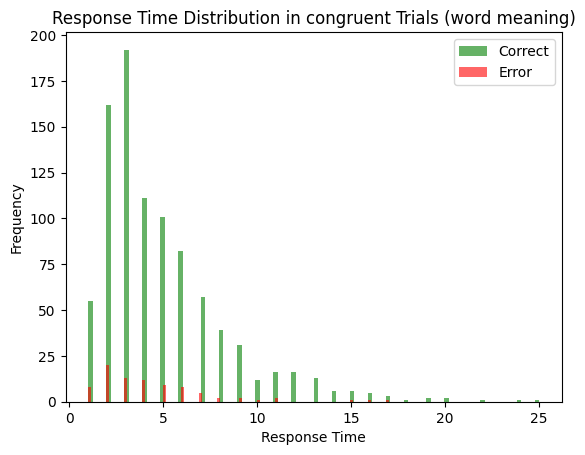

Average correct RT: 4.934426229508197
Accuracy: 0.915


In [94]:
comp, word_input, color_input, task_input = get_task_demand_stroop()

# example congruent stimulus (color naming)
rr_c = {word_input: [1, 0], color_input: [1, 0], task_input: [0, 1]}

comp.run(rr_c, num_trials= 1000)

results = comp.results# RED written in red

decision_times_correct = [r[1][0] for r in results if r[0][0] > 0]
decision_time_error = [r[1][0] for r in results if r[0][0] < 0]

plt.hist(decision_times_correct, bins=100, alpha=0.6, color='green', label='Correct')
plt.hist(decision_time_error, bins=100, alpha=0.6, color='red', label='Error')

plt.title('Response Time Distribution in congruent Trials (word meaning)')
plt.ylabel('Frequency')
plt.xlabel('Response Time')
plt.legend()
plt.show()
average_rt_congruent_color_naming = np.mean(decision_times_correct)
print(f'Average correct RT: {np.mean(decision_times_correct)}')
print(f'Accuracy: {len(decision_times_correct) / (len(decision_times_correct) + len(decision_time_error))}')

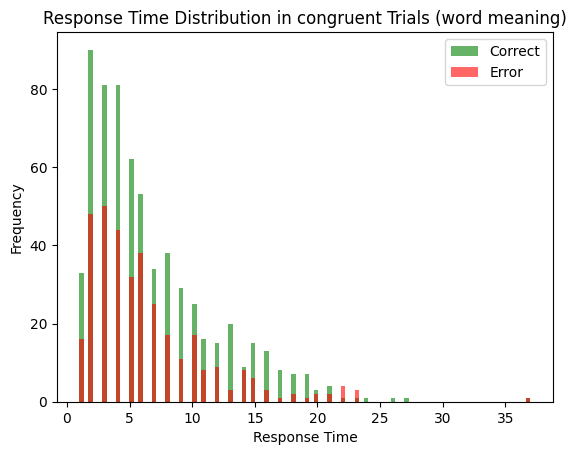

Average correct RT: 6.677966101694915
Accuracy: 0.649


In [95]:
comp, word_input, color_input, task_input = get_task_demand_stroop()

# example incongruent stimulus (color naming)
gr_c = {word_input: [0, 1], color_input: [1, 0], task_input: [0, 1]}

comp.run(gr_c, num_trials= 1000)

results = comp.results# RED written in red

decision_times_correct = [r[1][0] for r in results if r[0][0] > 0]
decision_time_error = [r[1][0] for r in results if r[0][0] < 0]

plt.hist(decision_times_correct, bins=100, alpha=0.6, color='green', label='Correct')
plt.hist(decision_time_error, bins=100, alpha=0.6, color='red', label='Error')

plt.title('Response Time Distribution in congruent Trials (word meaning)')
plt.ylabel('Frequency')
plt.xlabel('Response Time')
plt.legend()
plt.show()
average_rt_incongruent_color_naming = np.mean(decision_times_correct)
print(f'Average correct RT: {np.mean(decision_times_correct)}')
print(f'Accuracy: {len(decision_times_correct) / (len(decision_times_correct) + len(decision_time_error))}')

In [96]:
# Congruency effects:

print('Congruency Effects')
print('Word Reading:', average_rt_incongruent_word_reading - average_rt_congruent_word_reading)
print('Congruency Effects')
print('Color Naming:', average_rt_incongruent_color_naming - average_rt_congruent_color_naming)

Congruency Effects
Word Reading: 0.6256353735042861
Congruency Effects
Color Naming: 1.7435398721867186


## 4. Stroop With Conflict Monitoring

Remember: For our closed loop (later tonight) we want to investigate weather humans can adapt cognitive control. We want to see if more incongruent trials lead to less interference. However, the above model can not capture any sequential or adaptive effects.

To model this, we can add a control mechanism that monitors *conflict* and adapts how much task demand is applied to the word and color pathways. The idea: If we experience little conflict, for example because all the trials are word reading trials, or all of them are incongruent, we don't *need* the task_demand unit to answer correctly. Therefore, we can reduce its influence. However, if we experience a lot of conflict, for example because all the trials are reconfiguring, color naming trials, we need to increase the influence of the task_demand unit to answer correctly.

In our model, we add a control that monitors the `output layer` for conflict (i.e., both output units are highly activated). We also add a `task_hidden` unit with a logistic function. Its gain is modulated by the control mechanism. This way, the control mechanism can increase or decrease the influence of the task demand unit on the hidden word and color layers.


In [97]:
def get_conflict_monitoring_stroop():
    word_input = pnl.ProcessingMechanism(name="Word In", input_shapes=2)
    color_input = pnl.ProcessingMechanism(name="Color In", input_shapes=2)
    task_demand_input = pnl.ProcessingMechanism(name="Task Demand", input_shapes=2)

    word_hidden = pnl.ProcessingMechanism(name="Word Hidden", input_shapes=2, function=pnl.Logistic(bias=-4))
    color_hidden = pnl.ProcessingMechanism(name="Color Hidden", input_shapes=2, function=pnl.Logistic(bias=-4))
    # new task hidden that is modulated
    task_hidden = pnl.ProcessingMechanism(name="Task Hidden", input_shapes=2, function=pnl.Logistic(bias=-.5))

    # output layer (shape == 2 for one-hot encoded output red or green)
    output_layer = pnl.ProcessingMechanism(name="Output", input_shapes=2)

    control = pnl.ControlMechanism(name='Control',
                                   objective_mechanism=pnl.ObjectiveMechanism(
                                       name='Conflict Monitor',
                                       monitor=output_layer,
                                       function=pnl.Energy(input_shapes=2,
                                                           matrix=[[0, -0.5], [-0.5, 0]])),
                                   default_allocation=[1.],
                                   control_signals=[(pnl.GAIN, task_hidden)])

    # DDM for decision making
    decision_layer = pnl.DDM(
        name='Decision',
        input_format=pnl.ARRAY,
        function=pnl.DriftDiffusionIntegrator(
            noise=.5,
            rate=.05,
            threshold=1.
        ),
        reset_stateful_function_when=pnl.AtTrialStart())

    # create the compositions
    composition = pnl.Composition(name="Conflict Stroop")

    # Create the projections

    identity_matrix = np.array(
        [[1, -1],
         [-1, 1]])

    # scale the inhibition matrix by the processing strength
    word_hidden_matrix = WORD_STRENGTH * identity_matrix
    color_hidden_matrix = COLOR_STRENGTH * identity_matrix

    # create projections
    word_hidden_projection = pnl.MappingProjection(matrix=word_hidden_matrix)
    color_hidden_projection = pnl.MappingProjection(matrix=color_hidden_matrix)

    # Add pathways to the composition
    composition.add_linear_processing_pathway([
        word_input, word_hidden_projection, word_hidden
    ])

    composition.add_linear_processing_pathway([
        color_input, color_hidden_projection, color_hidden])

    # task -> task_hidden
    composition.add_linear_processing_pathway([task_demand_input, task_hidden])

    # task_hidden -> hidden (word and color)
    task_hidden_word_hidden_matrix = TASK_STRENGTH * np.array(
        [[1, 1],
         [0, 0]])
    task_hidden_color_hidden_matrix = TASK_STRENGTH * np.array(
        [[0, 0],
         [1, 1]]
    )

    task_word_hidden_projection = pnl.MappingProjection(matrix=task_hidden_word_hidden_matrix)
    task_color_hidden_projection = pnl.MappingProjection(matrix=task_hidden_color_hidden_matrix)

    composition.add_linear_processing_pathway([
        task_hidden,
        task_word_hidden_projection,
        word_hidden
    ])

    composition.add_linear_processing_pathway([
        task_hidden,
        task_color_hidden_projection,
        color_hidden
    ])

    word_matrix = WORD_STRENGTH * identity_matrix
    color_matrix = COLOR_STRENGTH * identity_matrix

    # create projections
    word_projection = pnl.MappingProjection(matrix=word_matrix)
    color_projection = pnl.MappingProjection(matrix=color_matrix)

    # hidden -> output
    composition.add_linear_processing_pathway([
        word_hidden, output_layer
    ])

    composition.add_linear_processing_pathway([
        color_hidden, output_layer
    ])

    # output -> decision

    composition.add_linear_processing_pathway([output_layer, decision_layer])

    composition.add_controller(control)

    def print_after():
        print('*' * 40)
        print(f'\t\t\t Trial')
        print(f'\tinput:\t\tword  color  task')
        print(f'\t\t\t {word_input.value[0]}    {color_input.value[0]}    {task_demand_input.value[0]}')
        print(f'\t\t\t {word_hidden.value[0]}    {color_hidden.value[0]}    {task_hidden.value[0]}')
        print(f'\t\t\t\tcolor  word')
        print(f'\ttask:\t\t{task_hidden.value[0]}')
        print(f'\ttask gain:\t   {task_hidden.parameter_ports[pnl.GAIN].value}')
        print(f'\t\t\t\tred   green')
        print(f'\toutput:\t\t{output_layer.value[0]}')
        print(f'\tdecision:\t{decision_layer.value[0]}{decision_layer.value[1]}')
        print(f'\tconflict:\t  {control.objective_mechanism.value[0]}')

    return composition, word_input, color_input, task_demand_input, print_after

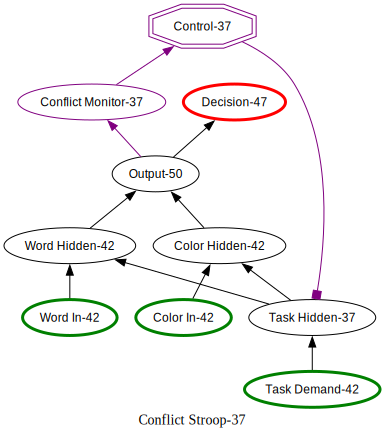

In [98]:
comp, _, _, _, _ = get_conflict_monitoring_stroop()
comp.show_graph(output_fmt='jupyter')

In [99]:
comp, word_input, color_input, task_input, print_after = get_conflict_monitoring_stroop()

# example incongruent stimulus (word meaning)


rg_w = {word_input: [1, 0], color_input: [0, 1], task_input: [0, 1]}
gg_c = {word_input: [1, 0], color_input: [1, 0], task_input: [1, 0]}

trials = {word_input: [], color_input: [], task_input: []}

def add_trial(trial_dict, num=100):
    for _ in range(num):
        trials[word_input].append(trial_dict[word_input])
        trials[color_input].append(trial_dict[color_input])
        trials[task_input].append(trial_dict[task_input])

import random
for _ in range(10):
    if random.random() > 0.1:
        add_trial(rg_w, num=1)
    else:
        add_trial(gg_c, num=1)



comp.run(trials, call_after_trial=print_after)

results = comp.results# RED written in red

decision_times_correct = [r[1][0] for r in results if r[0][0] < 0]
decision_time_error = [r[1][0] for r in results if r[0][0] > 0]
#
# plt.hist(decision_times_correct, bins=100, alpha=0.6, color='green', label='Correct')
# plt.hist(decision_time_error, bins=100, alpha=0.6, color='red', label='Error')
#
# plt.title('Response Time Distribution in Incongruent Trials (word reading)')
# plt.ylabel('Frequency')
# plt.xlabel('Response Time')
# plt.legend()
# plt.show()
# average_rt_incongruent_word_reading = np.mean(decision_times_correct)
# print(f'Average correct RT: {np.mean(decision_times_correct)}')
# print(f'Accuracy: {len(decision_times_correct) / (len(decision_times_correct) + len(decision_time_error))}')

****************************************
			 Trial
	input:		word  color  task
			 [1. 0.]    [0. 1.]    [0. 1.]
			 [0.62484461 0.00411154]    [0.02902445 0.62006811]    [0.37754067 0.62245933]
				color  word
	task:		[0.37754067 0.62245933]
	task gain:	   [1.]
				red   green
	output:		[0.65386906 0.62417965]
	decision:	[-1.][17.]
	conflict:	  [0.20406588]
****************************************
			 Trial
	input:		word  color  task
			 [1. 0.]    [0. 1.]    [0. 1.]
			 [0.71054974 0.0060481 ]    [0.01987816 0.52546408]    [0.47451387 0.52548613]
				color  word
	task:		[0.47451387 0.52548613]
	task gain:	   [0.20406588]
				red   green
	output:		[0.7304279  0.53151218]
	decision:	[-1.][3.]
	conflict:	  [0.19411566]
****************************************
			 Trial
	input:		word  color  task
			 [1. 0.]    [0. 1.]    [0. 1.]
			 [0.71156937 0.00607801]    [0.0197817  0.52422644]    [0.47575457 0.52424543]
				color  word
	task:		[0.47575457 0.52424543]
	task gain:	   [0.19411566]
			